<center> <img src="https://miro.medium.com/v2/resize:fit:300/0*gTbWMTKvNF-jLJrM.jpg" width=30% > </center>

<br><br>

<center> 
    <font size="6">Lab 3: Corner Detection, Optical Flow and Feature Tracking</font> 
</center>
<center> 
    <font size="4">Computer Vision 1 University of Amsterdam</font> 
</center>
<center> 
    <font size="4">Due 23:59, September 27, 2024 (Amsterdam time)</font> 
</center>
<center> 
    <font size="4"><b>TA's: Melis & Marina</b></font>
</center>

<br><br>

***

<br><br>

<center>

Student1 ID:  \
Student1 Name: 

Student2 ID: \
Student2 Name: 

Student3 ID: \
Student3 Name: 

( Student4 ID: \
Student4 Name: )

</center>

### **Import Libraries**

In [ ]:
import sys

if sys.version_info[0] < 3:
    raise Exception("Python 3 or a more recent version is required.")

In [13]:
# environment and libraries
import os
import math
import numpy as np
import time
import cv2
import matplotlib
import matplotlib.pyplot as plt
import sklearn
import scipy.signal
import pandas as pd
import torch

from tqdm import tqdm

from scipy.ndimage import maximum_filter, gaussian_filter

import torchvision.transforms.functional as F
from torchvision.io import read_video
from torchvision.models.optical_flow import Raft_Large_Weights, Raft_Small_Weights, raft_large, raft_small
from torchvision.utils import flow_to_image
from pathlib import Path
from IPython.display import clear_output, display, Video

In [14]:
# Make sure you're using the provided environment!
assert cv2.__version__ == "4.10.0", "You're not using the provided Python environment!"
assert np.__version__ == "1.26.4", "You're not using the provided Python environment!"
assert matplotlib.__version__ == "3.9.2", "You're not using the provided Python environment!"
# Proceed to the next cell if you don't get any error.

### **Instructions**

Your code and discussion must be handed in this jupyter notebook, renamed to **StudentID1_StudentID2_StudentID3.ipynb** before the deadline by submitting it to the Canvas Lab 3 Assignment. Please also fill out your names and ID's above.

For full credit, make sure your notebook follows these guidelines:
- It is mandatory to **use the Python environment provided** with the assignment; the environment specifies the package versions that have to be used to prevent the use of particular functions. Using different packages versions may lead to grade deduction. In the Python cell above you can check whether your environment is set up correctly.
- To install the environment with the right package versions, use the following command in your terminal: ```conda env create --file=CV1_environment.yaml```, then activate the environment using the command ```conda activate cv1```.
- Do not use additional packages or materials that have not been provided or explicitly mentioned.
- Please express your thoughts **concisely**. The number of words does not necessarily correlate with how well you understand the concepts.
- Answer all given questions and sub-questions.
- Try to understand the problem as much as you can. When answering a question, give evidences (qualitative and/or quantitative results, references to papers, figures etc.) to support your arguments. Note that not everything might be explicitly asked for and you are expected to think about what might strengthen you arguments and make the notebook self-contained and complete.
- Tables and figures must be accompanied by a **brief** description. Do not forget to add a number, a title, and if applicable name and unit of variables in a table, name and unit of axes and legends in a figure.

__Note:__ A more complete overview of the lab requirements can be found in the Course Manual on Canvas

Late submissions are not allowed. Assignments that are submitted after the strict deadline will not be graded. In case of submission conflicts, TAs’ system clock is taken as reference. We strongly recommend submitting well in advance, to avoid last minute system failure issues.

Plagiarism note: Keep in mind that plagiarism (submitted materials which are not your work) is a serious crime and any misconduct shall be punished with the university regulations. This includes the use of generative tools such as ChatGPT.

**ENSURE THAT YOU SAVE ALL RESULTS / ANSWERS ON THE QUESTIONS (EVEN IF YOU RE-USE SOME CODE).**

### **Overview**

- [Section 1: Harris Corner Detector (24 points)](#section-1)
  - [Question 1 (2 points)](#question-1)
  - [Question 2 (3 points)](#question-2)
  - [Question 3 (3 points)](#question-3)
  - [Question 4 (7 points)](#question-4)
  - [Question 5 (2 points)](#question-5)
  - [Question 6 (2 points)](#question-6)
  - [Question 7 (2 points)](#question-7)
  - [Question 8 (3 points)](#question-8)
- [Section 2: Good Features to Track (Shi & Tomasi) (10 points)](#section-2)
  - [Question 9 (3 points)](#question-9)
  - [Question 10 (4 points)](#question-10)
  - [Question 11 (3 points)](#question-11)
- [Section 3: Optical Flow and Lucas-Kanade Method (28 points)](#section-3)
  - [Question 12 (20 points)](#question-12)
  - [Question 13 (4 points)](#question-13)
  - [Question 14 (4 points)](#question-14)
- [Section 4: Feature Tracking (23 points)](#section-4)
  - [Question 15 (17 points)](#question-15)
  - [Question 16 (6 points)](#question-16)
- [Section 5: Optical Flow with RAFT Model (15 points)](#section-5)
  - [Question 17 (3 points)](#question-17)
  - [Question 18 (3 points)](#question-18)
  - [Question 19 (3 points)](#question-19)
  - [Question 20 (3 points)](#question-20)
  - [Question 21 (3 points)](#question-21)
- [Section X: Individual Contribution Report (Mandatory)](#section-x)

<a id="section-1"></a>
### **Section 1: Harris Corner Detector**

In this section, a derivation of the [Harris Corner Detector](https://www.semanticscholar.org/paper/A-Combined-Corner-and-Edge-Detector-Harris-Stephens/6818668fb895d95861a2eb9673ddc3a41e27b3b3) is presented.

Given a shift $(\Delta x,\Delta y)$ at a point $(x, y)$, the auto-correlation function is defined as:

$$
c(\Delta x,\Delta y) = \sum_{(x,y)\in W(x,y)} w(x,y) \left(I(x+\Delta x,y+\Delta y) - I(x,y)\right)^2 \tag{1}
$$

where $W(x,y)$ is a window centered at point $(x,y)$ and $w(x,y)$ is a Gaussian function. For simplicity, from now on, $\sum_{(x,y)\in W(x,y)}$ will be referred to as $\sum_{W}$.

Approximating the shifted function by the first-order Taylor expansion, we get:

$$
I(x+\Delta x, y+\Delta y) \approx I(x,y) + I_x(x,y)\Delta x + I_y(x,y)\Delta y \tag{2}
$$

This can be written in matrix form as:

$$
I(x+\Delta x, y+\Delta y) \approx I(x,y) + \begin{bmatrix} I_x(x,y) & I_y(x,y) \end{bmatrix} \begin{bmatrix} \Delta x \\ \Delta y \end{bmatrix} \tag{3}
$$

where $I_x$ and $I_y$ are partial derivatives of $I(x,y)$. The gradients can be approximated by:

$$
I_x \approx \frac{\partial I}{\partial x} \approx I * G_x, \quad G_x = (-1, 0, 1) \tag{4}
$$

$$
I_y \approx \frac{\partial I}{\partial y} \approx I * G_y, \quad G_y = \begin{bmatrix} -1 \\ 0 \\ 1 \end{bmatrix} \tag{5}
$$

Note that using the kernel $(-1, 1)$ to approximate the gradients is also correct. The auto-correlation function can now be written as:

$$
c(\Delta x,\Delta y) = \sum_{W} w(x,y) \left(I(x+\Delta x,y+\Delta y) - I(x,y)\right)^2 \tag{6}
$$

Using the first-order approximation, this becomes:

$$
c(\Delta x,\Delta y) \approx \sum_{W} w(x,y) \left( \begin{bmatrix} I_x(x,y) & I_y(x,y) \end{bmatrix} \begin{bmatrix} \Delta x \\ \Delta y \end{bmatrix} \right)^2 \tag{7}
$$

Which simplifies to:

$$
c(\Delta x, \Delta y) = \begin{bmatrix} \Delta x & \Delta y \end{bmatrix} Q(x,y) \begin{bmatrix} \Delta x \\ \Delta y \end{bmatrix} \tag{8}
$$

where $Q(x,y)$ is given by:

$$
Q(x,y) = \sum_{W} w(x,y) \begin{bmatrix} I_x(x,y)^2 & I_x(x,y)I_y(x,y) \\ I_x(x,y)I_y(x,y) & I_y(x,y)^2 \end{bmatrix} \tag{9}
$$

This can also be expressed as:

$$
Q(x,y) = \begin{bmatrix} \sum_{W} I_x(x,y)^2 \cdot w(x, y) & \sum_{W} I_x(x,y)I_y(x,y) \cdot w(x, y) \\ \sum_{W} I_x(x,y)I_y(x,y) \cdot w(x, y) & \sum_{W} I_y(x,y)^2 \cdot w(x, y) \end{bmatrix} \tag{10}
$$

Finally, we define:

$$
Q(x,y) = \begin{bmatrix} A & B \\ B & C \end{bmatrix} \tag{11}
$$

---

The *cornerness* $H(x,y)$ is defined by the two eigenvalues of $Q(x,y)$, denoted as $\lambda_1$ and $\lambda_2$:

$$
H = \lambda_1 \lambda_2 - 0.04(\lambda_1 + \lambda_2)^2 \tag{12}
$$

Alternatively, $H$ can be expressed in terms of the determinant and trace of $Q(x,y)$:

$$
H = \det(Q) - 0.04(\text{trace}(Q))^2 \tag{13}
$$

Which simplifies to:

$$
H = (AC - B^2) - 0.04(A+C)^2 \tag{14}
$$

In this section, you are going to implement Equation 12 to calculate $H$ and use it to detect corners in an image.

**Hint**: To compute $H$, you need to calculate the elements of **Q**, i.e., $A$, $B$, and $C$. Here's a step-by-step approach:

1. **Calculate $I_x$**: This is the smoothed derivative of the image $I$ along the x-direction. It can be obtained by convolving the first-order Gaussian derivative, $G_d$, with the image $I$ along the x-direction.

2. **Calculate $A$**: Once $I_x$ is computed, square $I_x$, and then convolve the result with a Gaussian, $G$.

3. **Calculate $B$**: This can be obtained similarly by calculating $I_x I_y$, where $I_y$ is the derivative of the image $I$ along the y-direction.

4. **Calculate $C$**: To compute $C$, convolve the image $I$ with $G_d$ along the y-direction to obtain $I_y$, square $I_y$, and then convolve it with the Gaussian $G$.

These steps will give you the elements needed to calculate $H$ using Equation 12 and detect corners in the image. The corner points are the local maxima of **H**. Therefore, for each point in $H$:

1. Check if it is greater than all its neighbors within an $n \times n$ window centered around this point.
2. Check if it is greater than a user-defined threshold.

If both conditions are met, then the point is labeled as a corner point.

<a id="question-1"></a>
#### <font color='#FF0000'>Question 1 (2 points)</font>

Implement the function `convert_image_to_grayscale` that reads an image from the given path and returns its grayscale version as a numpy array. The grayscale values should be normalized between 0 and 1.

**Hint:** Use the `cv2.imread` function with the appropriate flag to load the image in grayscale mode. Also, make sure to normalize the image values between 0 and 1.

In [1]:
def convert_image_to_grayscale(image_path):
    """
    Reads an image and returns its grayscale version.

    Args:
        image_path: Filepath of the image.

    Returns:
        normalized_grayscale_image: The grayscale image as a numpy array with values normalized between 0 and 1.
    """

    # YOUR CODE HERE
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    normalized_grayscale_image = image/255.0
    return normalized_grayscale_image

<a id="question-2"></a>
#### <font color='#FF0000'>Question 2 (3 points)</font>

Implement the function `compute_gradient_x` that calculates the gradient of a given grayscale image in the x direction. The function should return the gradient image as a numpy array.

**Hint:** Use the `convolve2d` function from `scipy.signal` to apply the convolution. Also, ensure that the output has the same dimensions as the input image.

In [16]:
from scipy.signal import convolve2d


def compute_gradient_x(grayscale_image):
    """
    Calculates the gradient of the image in the x direction.

    Args:
        grayscale_image: Grayscale image as a numpy array.

    Returns:
        gradient_x: A numpy array representing the gradient of the image in the x direction.
    """

    # YOUR CODE HERE
    sobel_x = np.array([
        [1, 0, -1],
        [2, 0, -2],
        [1, 0, -1]
    ])
    gradient_x = convolve2d(grayscale_image, sobel_x)

    return gradient_x

<a id="question-3"></a>
#### <font color='#FF0000'>Question 3 (3 points)</font>

Implement the function `compute_gradient_y` that calculates the gradient of a given grayscale image in the y direction. The function should return the gradient image as a numpy array.

**Hint:** Use the `convolve2d` function from `scipy.signal` to apply the convolution. Also, ensure that the output has the same dimensions as the input image.

In [17]:
def compute_gradient_y(grayscale_image):
    """
    Calculates the gradient of the image in the y direction.

    Args:
        grayscale_image: Grayscale image as a numpy array.

    Returns:
        gradient_y: A numpy array representing the gradient of the image in the y direction.
    """

    # YOUR CODE HERE
    sobel_y = np.array([
        [1, 2, 1],
        [0, 0, 0],
        [-1, -2, -1]
    ])
    gradient_y = scipy.signal.convolve2d(grayscale_image, sobel_y)

    return gradient_y

<a id="question-4"></a>
#### <font color='#FF0000'>Question 4 (7 points)</font>

Implement the function `harris_corner_detector` that detects corners in a grayscale image using the Harris Corner Detection algorithm. The function should read the image, convert it to grayscale, and then detect corners based on the provided sigma and threshold values.

Your function should return the Harris response matrix $H$, the indices of the rows of the detected corner points **rows**, and the indices of the columns of those points **columns**.

**Hint:** Use `scipy.ndimage.gaussian_filter` to apply Gaussian filtering to the products of the image gradients.

In [130]:
from numpy import linalg as LA
def harris_corner_detector(normalized_image, sigma, threshold):
    """
    Detects corners in a normalized grayscale image using the Harris Corner Detection algorithm.

    Args:
        normalized_image: Normalized grayscale image as a numpy array.
        sigma: Standard deviation for Gaussian filtering.
        threshold: Threshold for identifying strong corners.

    Returns:
        harris_response: The Harris response matrix (H).
        rows: The indices of the rows of detected corner points.
        columns: The indices of the columns of detected corner points.
    """

    # YOUR CODE HERE
    g_x, g_y = compute_gradient_x(normalized_image), compute_gradient_y(normalized_image)

    A = gaussian_filter(g_x*g_x, sigma, mode='constant')
    B = gaussian_filter(g_x*g_y, sigma, mode='constant')
    C = gaussian_filter(g_y*g_y, sigma, mode='constant')

    # each pixel now has a Q matrix, corresponding to [[A B], [B C]]
    print(f"A shape: {A.shape};    image shape: {normalized_image.shape}")
    h, w = normalized_image.shape
    Q = np.zeros((h, w, 2, 2))
    x_indices, y_indices = np.indices((h, w))

    # Fill in the array using broadcasting
    Q[:, :, 0, 0] = A[x_indices, y_indices]
    Q[:, :, 0, 1] = B[x_indices, y_indices]
    Q[:, :, 1, 0] = B[x_indices, y_indices]
    Q[:, :, 1, 1] = C[x_indices, y_indices]
    print(f"q shape: {Q.shape}")

    def calculate_harris_response(mat):
        mat = mat.reshape(2,2)
        eigenvalues, _ = LA.eig(mat)
        lam_one, lam_two = eigenvalues
        return lam_one*lam_two-0.04*(lam_one+lam_two)**2

    reshaped_Q = Q.reshape(h, w, 4, -1)  # shape: (h*w, 2, 2)
    # Apply the Harris response calculation
    harris_response_flat = np.apply_along_axis(calculate_harris_response, axis=2, arr=reshaped_Q)

    # Reshape back to the original dimensions minus the last two
    harris_response = harris_response_flat.reshape(Q.shape[:-2])

    neighborhood_size = 3
    filtered = maximum_filter(harris_response, neighborhood_size, mode='constant')
    mask = (harris_response == filtered)
    thresh_mask = np.zeros_like(harris_response, dtype=bool)
    thresh_mask[mask] = (harris_response[mask] > threshold)
    indices = np.argwhere(thresh_mask)
    print(mask.shape)
    rows = indices[:, 0]
    columns = indices[:, 1]


    return harris_response, rows, columns

<a id="question-5"></a>
#### <font color='#FF0000'>Question 5 (2 points)</font>

Implement a function `plot_harris_corner_detection_results` that plots three figures: The computed image derivatives $I_x$ and $I_y$, and the original image with the detected corner points plotted on it. 

In [175]:
def plot_harris_corner_detection_results(normalized_image, harris_response, rows, columns):
    """
    Plots the image derivatives I_x and I_y, and the original image with detected corner points.

    Args:
        normalized_image: Normalized grayscale image as a numpy array.
        harris_response: The Harris response matrix (H).
        rows: The indices of the rows of detected corner points.
        columns: The indices of the columns of detected corner points.

    Returns:
        None. Displays the plots.
    """

    # YOUR CODE HERE
    fig, axs = plt.subplots(4, figsize=(15,15))
    axs[0].imshow(normalized_image, cmap="gray")
    axs[0].scatter(columns, rows, color='red', s=10)
    axs[0].set_title('Original Image with Detected Corners')
    axs[0].axis('off')
    print("Min:", normalized_image.min(), "Max:", normalized_image.max())

    axs[1].imshow(compute_gradient_y(normalized_image), cmap="gray")
    axs[1].scatter(columns, rows, color='red', s=10)
    axs[1].set_title('Gradient in Y Direction')
    axs[1].axis('off')

    axs[2].imshow(compute_gradient_x(normalized_image), cmap="gray")
    axs[2].scatter(columns, rows, color='red', s=10)
    axs[2].set_title('Gradient in X Direction')
    axs[2].axis('off')

    axs[3].imshow(harris_response, cmap='hot')
    axs[3].set_title('Harris Response')
    axs[3].axis('off')

    plt.axis('off')

    plt.show()

<a id="question-6"></a>
#### <font color='#FF0000'>Question 6 (2 points)</font>

Write a script that loads an image, converts it to grayscale, detects corners using the Harris Corner Detection algorithm, and then plots the results using the `plot_harris_corner_detection_results` function.

Use the image **images/checkerboard.jpg** and experiment with the parameters. Make sure to adjust the parameters to effectively highlight the detected corners. Also, show the differences in the detected corners when changing the threshold value.

A shape: (482, 482);    image shape: (480, 480)
q shape: (480, 480, 2, 2)
(480, 480)
Min: 0.0 Max: 1.0


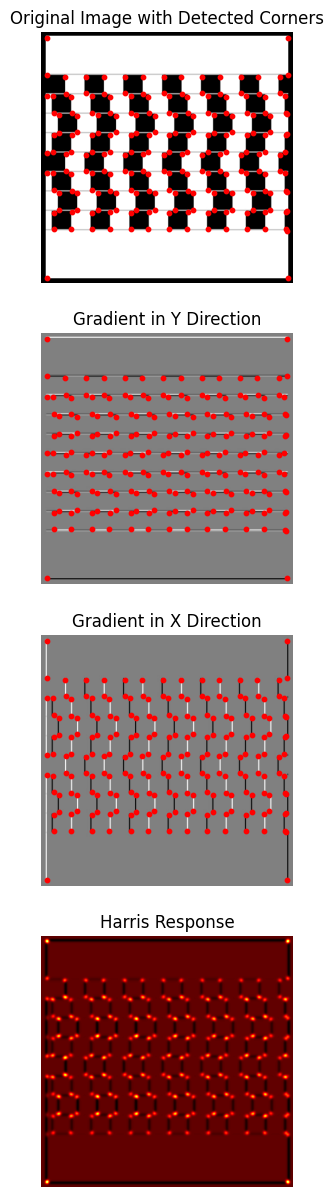

In [176]:
# YOUR CODE HERE
checkerboard = convert_image_to_grayscale("images/checkerboard.jpg")
h, r, c = harris_corner_detector(checkerboard, 3.0, 1.0)
plot_harris_corner_detection_results(checkerboard, h, r, c)

<a id="question-7"></a>
#### <font color='#FF0000'>Question 7 (2 points)</font>

Write a script that loads an image, converts it to grayscale, detects corners using the Harris Corner Detection algorithm, and then plots the results using the `plot_harris_corner_detection_results` function.

Use the image **images/house.jpg** and experiment with the parameters. Make sure to adjust the parameters to effectively highlight the detected corners.

A shape: (629, 1202);    image shape: (627, 1200)
q shape: (627, 1200, 2, 2)
(627, 1200)
Min: 0.0 Max: 1.0


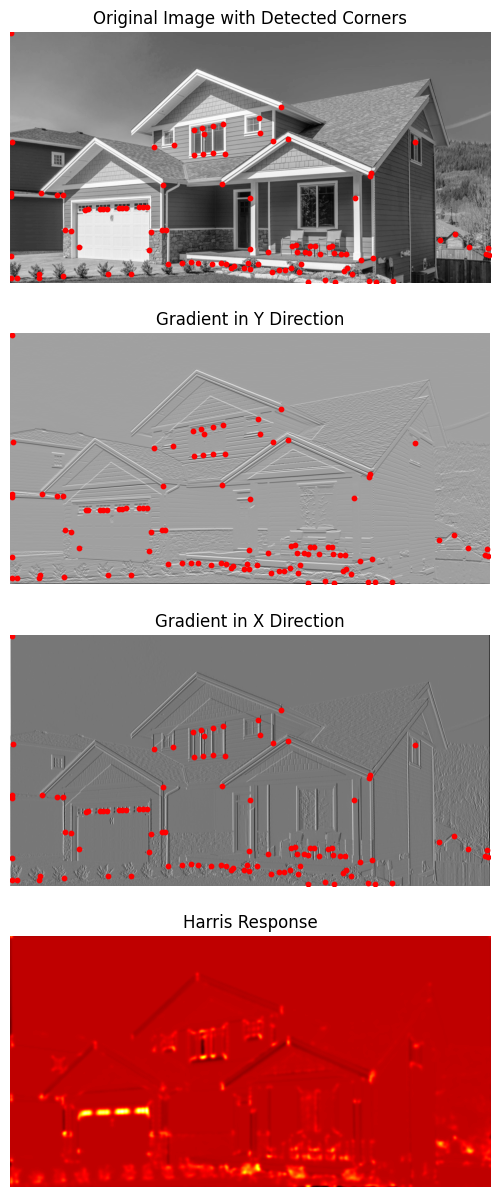

In [177]:
# YOUR CODE HERE
house = convert_image_to_grayscale("images/house.jpg")
h, r, c = harris_corner_detector(house, 4.0, 0.1)
plot_harris_corner_detection_results(house, h, r, c)

<a id="question-8"></a>
#### <font color='#FF0000'>Question 8 (5 points)</font>

Is the Harris Corner Detector algorithm rotation-invariant? How about your implementation? Rotate the **images/house.jpg** and **images/checkerboard.jpg** images by 45 and 90 degrees, and run the Harris Corner Detection algorithm on the rotated images.

Explain your answer and support it with your observations from both images.

##### <font color='yellow'>Answer:</font>

> *The Harris Corner Detector algorithm does not seem to be rotation-invariant as it seems that the number and location of the detected corner points differ between the unrotated and rotated images. This is apparent in the house image rotated 45 degrees, where the detected point on the right edge of the main window roof is missing. The point on the window on the right wall also seems to missing. Interestingly, these mistakes don't seem to appear for the checkerboard. Perhaps, because it has much more distinctly defined corners.*

A shape: (680, 680);    image shape: (678, 678)
q shape: (678, 678, 2, 2)
(678, 678)
Min: 0.0 Max: 1.0


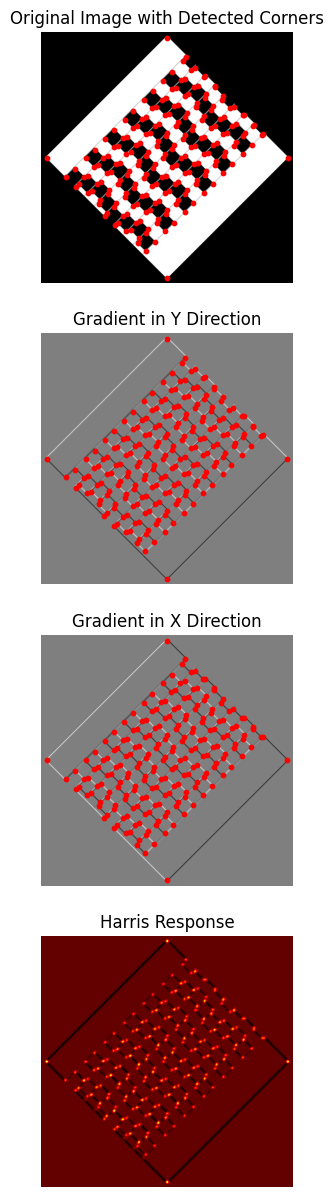

A shape: (482, 482);    image shape: (480, 480)
q shape: (480, 480, 2, 2)
(480, 480)
Min: 0.0 Max: 1.0


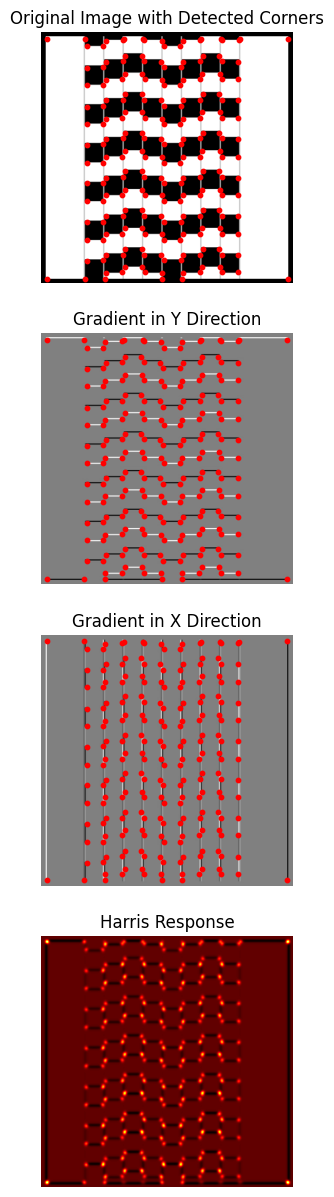

A shape: (1293, 1293);    image shape: (1291, 1291)
q shape: (1291, 1291, 2, 2)
(1291, 1291)
Min: 0.0 Max: 1.0


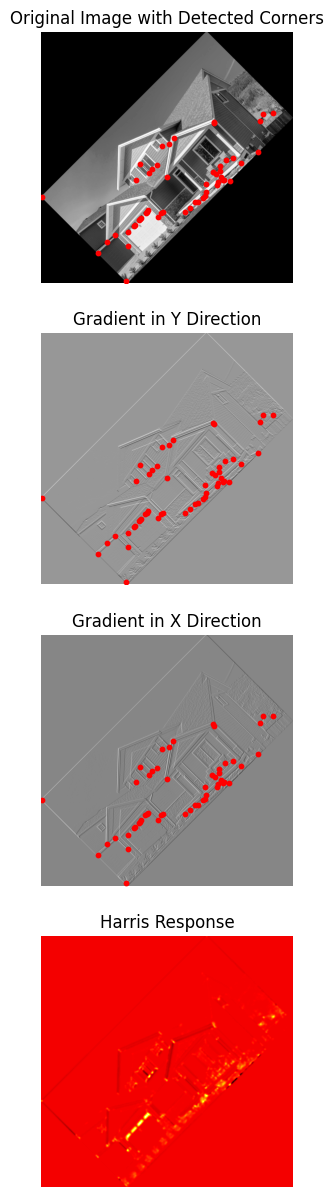

A shape: (1202, 629);    image shape: (1200, 627)
q shape: (1200, 627, 2, 2)
(1200, 627)
Min: 0.0 Max: 1.0


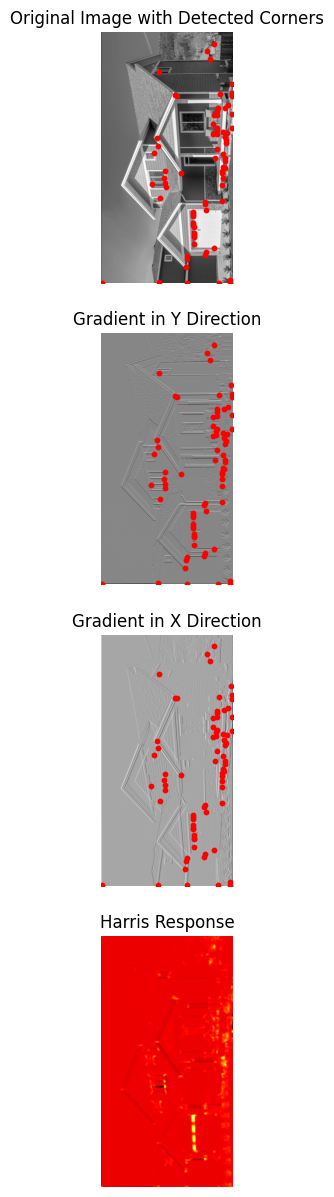

In [179]:
# YOUR CODE HERE
def rotate_image(image, angle):
    (h, w) = image.shape[:2]

    center = (w // 2, h // 2)

    M = cv2.getRotationMatrix2D(center, angle, 1.0)

    abs_cos = abs(M[0, 0])
    abs_sin = abs(M[0, 1])

    new_w = int(h * abs_sin + w * abs_cos)
    new_h = int(h * abs_cos + w * abs_sin)

    M[0, 2] += new_w / 2 - center[0]
    M[1, 2] += new_h / 2 - center[1]

    rotated_image = cv2.warpAffine(image, M, (new_w, new_h))

    return rotated_image
rotated_checkerboard_45 = rotate_image(checkerboard, 45)
rotated_house_45 = rotate_image(house, 45)

rotated_checkerboard_90 = rotate_image(checkerboard, 90)
rotated_house_90 = rotate_image(house, 90)


h, r, c = harris_corner_detector(rotated_checkerboard_45, 3.0, 1.0)
plot_harris_corner_detection_results(rotated_checkerboard_45, h, r, c)

h, r, c = harris_corner_detector(rotated_checkerboard_90, 3.0, 1.0)
plot_harris_corner_detection_results(rotated_checkerboard_90, h, r, c)

h, r, c = harris_corner_detector(rotated_house_45, 4.0, 0.1)
plot_harris_corner_detection_results(rotated_house_45, h, r, c)
h, r, c = harris_corner_detector(rotated_house_90, 4.0, 0.1)
plot_harris_corner_detection_results(rotated_house_90, h, r, c)

<a id="section-2"></a>
### **Section 2: Good Features to Track (Shi & Tomasi)**

In this section, you will explore another definition of cornerness, introduced by *[Shi and Tomasi](https://ieeexplore.ieee.org/document/323794)*, which builds upon the original Harris definition discussed in Equation (12). Their algorithm presents an alternative approach to detecting good features for tracking. The upcoming questions will guide you through understanding and comparing their method to the Harris corner detection algorithm.

<a id="question-9"></a>
#### <font color='#FF0000'>Question 9 (3 points)</font>

How do Shi and Tomasi define cornerness? Write down their definition using the notations from **Equation (12)**.

##### <font color='yellow'>Answer:</font>

> *Write your answer here.*

<a id="question-10"></a>
#### <font color='#FF0000'>Question 10 (4 points)</font>

Does the Shi-Tomasi Corner Detector satisfy the properties of translation invariance, rotation invariance, and scale invariance? For each of these properties, explain whether the algorithm meets it and provide clear reasoning to support your answer.

##### <font color='yellow'>Answer:</font>

> *Write your answer here.*

<a id="question-11"></a>
#### <font color='#FF0000'>Question 11 (3 points)</font>

In the following scenarios, what could be the relative cornerness values assigned by Shi and Tomasi? Explain your reasoning.

1. Both eigenvalues are near 0.  
2. One eigenvalue is large, and the other is near zero.  
3. Both eigenvalues are large.

##### <font color='yellow'>Answer:</font>

> *Write your answer here.*

<a id="section-3"></a>
### **Section 3: Optical Flow and Lucas-Kanade Method**

In this section, a derivation of the *Optical Flow* algorithm and its implementation using the *[Lucas-Kanade method](https://www.ri.cmu.edu/pub_files/pub3/lucas_bruce_d_1981_2/lucas_bruce_d_1981_2.pdf)* for Optical Flow estimation is presented.

Optical flow refers to the apparent motion of image pixels or regions from one frame to the next, caused by moving objects in the scene or camera motion. A key assumption in optical flow is the *brightness constancy* assumption, which states that image values (such as brightness or color) remain constant over time, even if their 2D position changes in the image.

Algorithms for estimating optical flow use this assumption to compute a velocity field that describes the horizontal and vertical motion of each pixel in the image. For a 2D+t dimensional case, a voxel at location $(x, y, t)$ with intensity $I(x, y, t)$ will have moved by $\delta_x$, $\delta_y$, and $\delta_t$ between two image frames. This results in the following image constraint equation:

\begin{equation}
I(x, y, t) = I(x + \delta_x, y + \delta_y, t + \delta_t). \tag{15}
\end{equation}

Assuming the movement is small, the image constraint at $I(x, y, t)$ can be approximated using the first-order Taylor expansion:

\begin{equation}
I(x + \delta_x, y + \delta_y, t + \delta_t) \approx I(x, y, t) + \frac{\partial I}{\partial x} \delta_x + \frac{\partial I}{\partial y} \delta_y + \frac{\partial I}{\partial t} \delta_t \tag{16}
\end{equation}

Since changes in the image are assumed to be purely due to movement, we get:

\begin{equation}
\frac{\partial I}{\partial x} \frac{\delta_x}{\delta_t} + \frac{\partial I}{\partial y} \frac{\delta_y}{\delta_t} + \frac{\partial I}{\partial t} \frac{\delta_t}{\delta_t} = 0 \tag{17}
\end{equation}

or more concisely:

\begin{equation}
I_x V_x + I_y V_y = -I_t, \tag{18}
\end{equation}

where $V_x$ and $V_y$ are the $x$ and $y$ components of the velocity (or optical flow) of $I(x, y, t)$. Here, $I_x$, $I_y$, and $I_t$ are the partial derivatives of the image at $(x, y, t)$ with respect to $x$, $y$, and $t$, respectively. This is the main equation for optical flow.

Optical flow is challenging to compute for two main reasons:

1. **Ambiguity in homogeneous regions**: In image regions with uniform brightness, the optical flow is ambiguous because the brightness constancy assumption can be satisfied by multiple different motions.

2. **Violation of the brightness constancy assumption**: In real-world scenes, the brightness constancy assumption can be violated at motion boundaries or due to factors such as changing lighting, non-rigid motions, shadows, transparency, reflections, etc.

To resolve the ambiguity in homogeneous regions, optical flow methods often make additional assumptions about the spatial variation of the flow field. These assumptions are approximate and may introduce errors in the estimated flow. The second problem can be addressed by using robust statistical methods or more complex models that can handle violations of the brightness constancy assumption.

The *Lucas-Kanade method* assumes that the optical flow remains constant within a local neighborhood of the pixel being considered. Therefore, the main equation of optical flow holds for all pixels in a small window centered at the pixel in question. Let's consider a pixel $p$. For all pixels around $p$, the local image flow vector $(V_x, V_y)$ must satisfy the following system of equations:

\begin{equation}
I_x(q_1)V_x + I_y(q_1)V_y = - I_t(q_1) \tag{19}
\end{equation}

\begin{equation}
I_x(q_2)V_x + I_y(q_2)V_y = - I_t(q_2) \tag{19}
\end{equation}

$$ \vdots $$

\begin{equation}
I_x(q_n)V_x + I_y(q_n)V_y = - I_t(q_n) \tag{19}
\end{equation}

where $q_1$, $q_2$, ... $q_n$ are the pixels inside the window around $p$, and $I_x(q_i)$, $I_y(q_i)$, and $I_t(q_i)$ are the partial derivatives of the image $I$ with respect to $x$, $y$, and $t$, evaluated at each point $q_i$.

This system can be rewritten in matrix form as $Av = b$, where:

\begin{equation}
A = \begin{bmatrix}
I_x(q_1) & I_y(q_1) \\
I_x(q_2) & I_y(q_2) \\
\vdots   & \vdots   \\
I_x(q_n) & I_y(q_n)
\end{bmatrix}, 
v = \begin{bmatrix}
V_x \\
V_y
\end{bmatrix}, 
b = \begin{bmatrix}
-I_t(q_1) \\
-I_t(q_2) \\
\vdots   \\
-I_t(q_n)
\end{bmatrix} \tag{20}
\end{equation}

Since this system has more equations than unknowns, it is typically over-determined. The Lucas-Kanade method solves this using the weighted least-squares principle, obtaining an approximate solution by minimizing the squared error. This results in solving the following $2 \times 2$ system:

\begin{equation}
A^T A v = A^T b \tag{21}
\end{equation}

or equivalently:

\begin{equation}
v = (A^T A)^{-1} A^T b \tag{22}
\end{equation}

In this solution, $A^T A$ is a $2 \times 2$ matrix, and $(A^T A)^{-1}$ is its inverse. This allows us to compute the local velocity components $V_x$ and $V_y$ for the pixel $p$.

<a id="question-12"></a>
#### <font color='#FF0000'>Question 12 (20 points)</font>

For this question, you will be given four pairs of images: **sphere1.jpg**, **sphere2.jpg**; **plant1.jpg**, **plant2.jpg**; **car1.jpg**, **car2.jpg**;  and **table1.jpg**, **table2.jpg**. You are required to estimate the optical flow between each pair of images using the Lucas-Kanade algorithm.

First, divide the input images into non-overlapping regions, each of size $20 \times 20$ pixels. For each region, compute the matrix $A$, its transpose $A^T$, and the vector $b$. Then, estimate the optical flow for that region using the equation:

$$ v = (A^T A)^{-1} A^T b $$

You will implement the function `compute_image_derivatives` to calculate the x, y, and time derivatives of the images. Next, use the function `calculate_image_subregions` to divide the image derivatives into non-overlapping subregions. Afterward, estimate the optical flow for each subregion using the function `calculate_optical_flow_for_subregions`, which solves the linear system for each subregion.

Once you have the optical flow estimates $(V_x, V_y)$ for each region, visualize the results. For this, use the function `plot_optical_flow_with_images` to display frame 1, frame 2, and the optical flow vectors. The **matplotlib** function `quiver` will help you plot the optical flow vectors as arrows on the image. Additionally, you will implement the function `calculate_optical_flow_lucas_kanade` to handle the complete process of optical flow estimation and subregion management.

Finally, include a demo function to load the images and call the necessary functions to compute and plot the optical flow.

**Note**: You can use non-overlapping regions of size $20 \times 20$ pixels. For example, if the input images are $256 \times 256$, you should obtain a $12 \times 12$ grid of optical flow vectors. For each region, the matrix $\textbf{A}$ will have dimensions $400 \times 2$, and the vector $\mathbf{b}$ will have dimensions $400 \times 1$. When performing convolutions, you can use `scipy.signal.convolve2d`. While using the **matplotlib** `quiver` function, be mindful that by default, the angles of the arrows are 45 degrees counterclockwise from the horizontal axis, which may cause them to point in the wrong direction. Ensure to adjust for this and experiment with scaling to properly visualize the optical flow vectors.

In [ ]:
def compute_image_derivatives(image_time_0, image_time_1):
    """
    Computes the x, y, and time derivatives of an image.
    
    Args:
        image_time_0: Grayscale image at time t0 as a numpy array.
        image_time_1: Grayscale image at time t1 as a numpy array.
    
    Returns:
        image_derivative_x: Derivative of the image in the x direction.
        image_derivative_y: Derivative of the image in the y direction.
        image_derivative_time: Derivative of the image in time (t0 - t1).
    """
    
    # YOUR CODE HERE
    
    return image_derivative_x, image_derivative_y, image_derivative_time

In [ ]:
def calculate_image_subregions(image_time_0, image_derivative_x, image_derivative_y, image_derivative_time, region_size):
    """
    Divides the image derivatives into subregions of the given size.
    
    Args:
        image_time_0: Grayscale image at time t0.
        image_derivative_x: Derivative of the image in the x direction.
        image_derivative_y: Derivative of the image in the y direction.
        image_derivative_time: Time derivative of the image.
        region_size: The size of each subregion.
    
    Returns:
        subregions_derivative_x: List of subregions of the image x-derivative.
        subregions_derivative_y: List of subregions of the image y-derivative.
        subregions_derivative_time: List of subregions of the image time-derivative.
    """
    
    # YOUR CODE HERE
    
    return subregions_derivative_x, subregions_derivative_y, subregions_derivative_time

In [ ]:
def calculate_optical_flow_for_subregions(subregion_derivatives_x, subregion_derivatives_y, subregion_derivatives_time):
    """
    Estimates the optical flow for each subregion by solving the linear system.
    
    Args:
        subregion_derivatives_x: List of x-derivative subregions.
        subregion_derivatives_y: List of y-derivative subregions.
        subregion_derivatives_time: List of time-derivative subregions.
    
    Returns:
        flow_vectors_x: List of optical flow estimates in the x direction for each subregion.
        flow_vectors_y: List of optical flow estimates in the y direction for each subregion.
    """
    
    # YOUR CODE HERE
    
    return flow_vectors_x, flow_vectors_y

In [ ]:
def calculate_optical_flow_lucas_kanade(image_time_0, image_time_1, region_size=20):
    """
    Estimates optical flow between two images using the Lucas-Kanade method.
    
    Args:
        image_time_0: Grayscale image at time t0.
        image_time_1: Grayscale image at time t1.
        region_size: The size of each subregion for optical flow estimation.
    
    Returns:
        subregion_centers: The center coordinates of each subregion.
        flow_vectors_x: Optical flow vectors in the x direction.
        flow_vectors_y: Optical flow vectors in the y direction.
    """
    
    # YOUR CODE HERE
    
    return subregion_centers, flow_vectors_x, flow_vectors_y

In [ ]:
def plot_optical_flow_with_images(image_time_0, image_time_1, subregion_centers, flow_vectors_x, flow_vectors_y):
    """
    Plots frame 1, frame 2, and the optical flow vectors in a 3-column subplot.
    
    Args:
        image_time_0: Grayscale image at time t0.
        image_time_1: Grayscale image at time t1.
        subregion_centers: The center coordinates of each subregion.
        flow_vectors_x: Optical flow vectors in the x direction.
        flow_vectors_y: Optical flow vectors in the y direction.
    
    Returns:
        None. Displays the subplot with optical flow and images.
    """
    
    # YOUR CODE HERE
    
    return  

In [ ]:
# YOUR CODE HERE

<a id="question-13"></a>
#### <font color='#FF0000'>Question 13 (4 points)</font>

Compare the Lucas-Kanade method and the *[Horn-Schunck method](https://www.sciencedirect.com/science/article/abs/pii/0004370281900242)* in terms of the scale at which they operate (local or global), and explain your answer.

##### <font color='yellow'>Answer:</font>

> *Write your answer here.*

<a id="question-14"></a>
#### <font color='#FF0000'>Question 14 (4 points)</font>

Compare the behavior of the Lucas-Kanade method and the *[Horn-Schunck method](https://www.sciencedirect.com/science/article/abs/pii/0004370281900242)* in flat regions of the image. Explain the differences or similarities between the two algorithms.

##### <font color='yellow'>Answer:</font>

> *Write your answer here.*

<a id="section-4"></a>
### **Section 4: Feature Tracking**

In this section of the assignment, you will develop a basic feature-tracking algorithm, a fundamental tool in computer vision. The goal is to detect visual features, such as corners or other distinct points of interest, and track their movement across multiple frames in a video or image sequence. 

Feature tracking is a crucial step in many applications, including motion detection, object recognition, and 3D reconstruction. By accurately identifying and following key features, you can gain insight into how objects move and interact over time. 

<a id="question-15"></a>
#### <font color='#FF0000'>Question 15 (17 points)</font>

In this question, you will implement a basic feature-tracking algorithm. First, detect feature points on the first frame of each image sequence using the **Harris Corner Detector** from **Section 1**. Then, track these points across subsequent frames using the **Lucas-Kanade algorithm** for optical flow estimation, which you implemented in **Section 2**.

Your task is to complete the function `calculate_optical_flow_at_corners`, which should track the corners from the first frame and compare them to the corners in the current frame. You can take inspiration from your `calculate_optical_flow_for_subregions` function, adapting it to process individual corners rather than subregions.

After completing this, you also need to finish the `process_sequence` function, which computes and visualizes the optical flow over an entire image sequence and saves the results as a video. The steps involve loading consecutive frames from the image sequence, converting them to grayscale, detecting corners in the first frame, computing the image gradients between frames, and calculating optical flow at the detected corners. Finally, the results will be visualized using flow vectors and saved as a video.

In [ ]:
def calculate_optical_flow_at_corners(image_gradient_x, image_gradient_y, image_gradient_t, corners, window_size):
    """
    Calculates optical flow vectors at the provided corners using the Lucas-Kanade method.

    Args:
        image_gradient_x: Gradient of the image along the x-axis.
        image_gradient_y: Gradient of the image along the y-axis.
        image_gradient_t: Temporal gradient between two consecutive frames.
        corners: Tuple of (row, column) indices where corners are detected.
        window_size: Size of the window used for computing flow.

    Returns:
        valid_corners: List of valid corners where flow was computed.
        flow_vectors: List of optical flow vectors (u, v) for each corner.
    """
    half_window_size = window_size // 2
    valid_corners = []
    flow_vectors = []

    # YOUR CODE HERE

    return valid_corners, flow_vectors

In [ ]:
def process_sequence(sequence_name,
                     sigma=1.5,
                     corner_threshold=0.001,
                     window_size=5,
                     scaling_factor=1):
    """
    Processes an image sequence to compute and visualize optical flow,
    saving the result as a video using OpenCV.

    Args:
        sequence_name: Name of the image sequence ('basketball' or 'toy').
        sigma: Standard deviation for Gaussian filtering in Harris corner detection.
        corner_threshold: Threshold for detecting strong corners.
        window_size: Size of the window used for optical flow calculations.
        scaling_factor: Scaling factor for the flow vectors in the visualization.

    Returns:
        None. Saves the visualization video in the current directory.
    """

    # YOUR CODE HERE

<a id="question-16"></a>
#### <font color='#FF0000'>Question 16 (6 points)</font>  

For this part, you are required to prepare a video for each image sequence, showing both the initial feature points and their tracked optical flow over time. You should test your implementation and generate visualization videos for the **basketball** and **toy** sequences, ensuring the visualizations clearly display the feature points and the optical flow vectors. The frames for the **basketball** sequence can be found inside the `frames/basketball/` directory, and the frames for the **toy** sequence are located in `frames/toy/`.

**Note**: To visualize the videos directly inside the notebook, you should use the `Video` function from **IPython.display**. This will allow you to render the video output within the notebook, making it easier to review your results without needing an external video player. Make sure the path to the video file is correctly specified, and the video is in a supported format (e.g., `.mp4`). Ensure that the video format is **mp4** and encoded using `fourcc = cv2.VideoWriter_fourcc(*'avc1')` to guarantee compatibility with most players and browsers.

In [ ]:
# YOUR CODE HERE (for the basketball sequence)

In [ ]:
# YOUR CODE HERE (for the toy sequence)

<a id="section-5"></a>
### **Section 5: Optical Flow with RAFT Model**

In this section, you will work with code to run, test, and play with the RAFT optical flow model. RAFT (Recurrent All-Pairs Field Transforms) is a powerful deep learning model for predicting the motion of objects between consecutive video frames. The code provided will allow you to predict optical flow between selected frame pairs from a video.

The function `optical_flow_prediction` lets you choose between two different versions of the RAFT model: one with **small weights** and another with **large weights**. Depending on your machine's specs, you can switch between these two options by setting the `weight_type` parameter to either `'small'` or `'large'`. If you're using a lower-spec laptop or computer, the small weight model is recommended for faster performance, while the large weight model provides more accuracy but requires more computational power.

You will also need to install the `av` package, which is required to process video frames. You can install it using the following command: `pip install av`

RAFT is a state-of-the-art deep learning model for optical flow estimation, known for its high accuracy and efficiency. It works by comparing all pixel pairs between two consecutive frames and iteratively refining the flow predictions using a recurrent neural network. This method enables RAFT to capture detailed motion in complex scenes. For a deeper understanding of the architecture and techniques behind RAFT, which you can find in the paper: [RAFT: Recurrent All-Pairs Field Transforms for Optical Flow](https://arxiv.org/abs/2003.12039).

In [ ]:
def plot_optical_flow(img1_batch, img2_batch, flow_imgs):
    """
    Plots the original frames and their corresponding optical flow side by side.

    Args:
        img1_batch: Batch of the first frames from each pair of consecutive frames.
        img2_batch: Batch of the second frames from each pair of consecutive frames.
        flow_imgs: Batch of predicted optical flow images corresponding to each frame pair.

    Returns:
        None. Displays the original frames and optical flow visualization in a grid format.
    """

    num_images = len(img1_batch)
    _, axs = plt.subplots(nrows=num_images, ncols=3, figsize=(12, 6), squeeze=False)

    for idx in range(num_images):
        img1 = F.to_pil_image(img1_batch[idx].to("cpu"))
        img2 = F.to_pil_image(img2_batch[idx].to("cpu"))
        flow_img = F.to_pil_image(flow_imgs[idx].to("cpu"))

        # Frame 1
        axs[idx, 0].imshow(np.asarray(img1))
        axs[idx, 0].set_title(f'Frame 1 - Pair {idx + 1}')
        axs[idx, 0].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

        # Frame 2
        axs[idx, 1].imshow(np.asarray(img2))
        axs[idx, 1].set_title(f'Frame 2 - Pair {idx + 1}')
        axs[idx, 1].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

        # Optical Flow
        axs[idx, 2].imshow(np.asarray(flow_img))
        axs[idx, 2].set_title(f'Optical Flow - Pair {idx + 1}')
        axs[idx, 2].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    plt.tight_layout()
    plt.show()

In [ ]:
def optical_flow_prediction(weight_type='small', frame_pairs=[(100, 101), (150, 151)]):
    """
    Predicts optical flow between pairs of consecutive frames from a video using the RAFT model.

    Args:
        weight_type: Specifies the RAFT model's weight type ('small' or 'large') for optical flow prediction.
        frame_pairs: List of tuples, where each tuple contains two frame indices representing consecutive frames
                     (default: [(100, 101), (150, 151)]).

    Returns:
        None. Visualizes the optical flow between the selected frames.
    """

    # Define the local video path
    video_path = Path("video/basketballer.mp4")

    # Read video frames using torchvision's `read_video` and use `pts_unit='sec'` to avoid warnings
    frames, _, _ = read_video(str(video_path), output_format="TCHW", pts_unit="sec")

    # Select the pairs of consecutive frames based on the provided frame_pairs argument
    img1_batch = torch.stack([frames[pair[0]] for pair in frame_pairs])
    img2_batch = torch.stack([frames[pair[1]] for pair in frame_pairs])

    # Prepare the images for input to the RAFT model
    if weight_type == 'small':
        weights = Raft_Small_Weights.DEFAULT
        model_fn = raft_small
    elif weight_type == 'large':
        weights = Raft_Large_Weights.DEFAULT
        model_fn = raft_large
    else:
        raise ValueError("weight_type must be either 'small' or 'large'")

    transforms = weights.transforms()
    img1_batch = F.resize(img1_batch, size=[520, 960], antialias=False)
    img2_batch = F.resize(img2_batch, size=[520, 960], antialias=False)
    img1_batch, img2_batch = transforms(img1_batch, img2_batch)

    # Define the device (GPU if available, otherwise CPU)
    device = "cuda" if torch.cuda.is_available() else "cpu"

    # Load the RAFT model with pre-trained weights based on the chosen weight type
    model = model_fn(weights=weights, progress=True).to(device).eval()

    # Predict the optical flow between the pairs of images
    list_of_flows = model(img1_batch.to(device), img2_batch.to(device))

    # Select the final flow prediction (last iteration is the most accurate)
    predicted_flows = list_of_flows[-1]

    # Convert the flow tensor into an RGB image for visualization
    flow_imgs = flow_to_image(predicted_flows)

    # Adjust the original frames for plotting (convert from [-1, 1] to [0, 1])
    img1_batch = [(img1 + 1) / 2 for img1 in img1_batch]
    img2_batch = [(img2 + 1) / 2 for img2 in img2_batch]

    # Call the function to plot the frames and their corresponding optical flow
    plot_optical_flow(img1_batch, img2_batch, flow_imgs)

In [ ]:
# Call the function to run the optical flow prediction and visualization
optical_flow_prediction(weight_type='large', frame_pairs=[(100, 101), (150, 151)])

<a id="question-17"></a>
#### <font color='#FF0000'>Question 17 (3 points)</font>

After running the provided code, you see two different frame pairs and the optical flow predictions for each. In the flow visualization, objects like the ball are shown in different colors in the two frame pairs. Explain what the colors represent in the optical flow and why the ball appears in a different color in the two frame pairs.

##### <font color='yellow'>Answer:</font>

> *Write your answer here.*

<a id="question-18"></a>
#### <font color='#FF0000'>Question 18 (3 points)</font>

Both the Lucas-Kanade and the Horn-Schunk methods work with assumptions about the conditions of the images. Give one example for each of these methods in which they might have trouble, and explain whether RAFT suffers from the same problem and why this might be the case.

##### <font color='yellow'>Answer:</font>

> *Write your answer here.*

<a id="question-19"></a>
#### <font color='#FF0000'>Question 19 (3 points)</font>

What are the three main components of the RAFT architecture? Briefly explain each component.

##### <font color='yellow'>Answer:</font>

> *Write your answer here.*

<a id="question-20"></a>
#### <font color='#FF0000'>Question 20 (3 points)</font>

What advantage does RAFT offer by maintaining a single fixed flow field at high resolution instead of using a coarse-to-fine strategy?

##### <font color='yellow'>Answer:</font>

> *Write your answer here.*

<a id="question-21"></a>
#### <font color='#FF0000'>Question 21 (3 points)</font>

Explain how RAFT’s correlation pyramid works and how it helps in estimating flow across large and small displacements.

##### <font color='yellow'>Answer:</font>

> *Write your answer here.*

<a id="section-x"></a>
### **Section X: Individual Contribution Report *(Mandatory)***

Because we want each student to contribute fairly to the submitted work, we ask you to fill out the textcells below. Write down your contribution to each of the assignment components in percentages. Naturally, percentages for one particular component should add up to 100% (e.g. 30% - 30% - 40%). No further explanation has to be given.

| Name | Contribution on Research | Contribution on Programming | Contribution on Writing |
| -------- | ------- | ------- | ------- |
|  | - % | - % | - % |
|  | - % | - % | - % |
|  | - % | - % | - % |
|  | - % | - % | - % |

### - End of Notebook -